In [64]:
__author__ = 'Erwin Chen'
# %matplotlib nbagg
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.metrics.cluster import v_measure_score
from sklearn.covariance import EmpiricalCovariance, MinCovDet, EllipticEnvelope

In [2]:
# # load data from APOGEE
# load data from fits file
apogee_file = fits.open('allStar-v603.fits')
apogee_file.info()
apogee_data = apogee_file[1].data
# APOGEE ID for stars
ap_ID = apogee_data.field('APOGEE_ID')
# Galactic Longitude
ap_l = apogee_data.field('GLON')
# Galactic Latitude 
ap_b = apogee_data.field('GLAT')
# Right Ascension(J2000)
ap_RA = apogee_data.field('RA')
# Declination(J2000)
ap_DEC = apogee_data.field('DEC')
# Heliocentric radial velocity
ap_RV = apogee_data.field('VHELIO_AVG')
# log g
ap_LOGG = apogee_data.field('LOGG')
# Effective Temperature
ap_TEFF = apogee_data.field('TEFF')
# Proper Motion
ap_PMRA = apogee_data.field('PMRA')
ap_PMDEC = apogee_data.field('PMDEC')
# 15 elements
elements = np.array(["Al", "Ca", "C", "Fe", "K", "Mg", "Mn", "Na", "Ni", "N", "O", "Si", "S", "Ti", "V"])
ap_AL_H = apogee_data.field("AL_H")
ap_CA_H = apogee_data.field("CA_H")
ap_C_H = apogee_data.field("C_H")
ap_FE_H = apogee_data.field('FE_H')
ap_K_H = apogee_data.field("K_H")
ap_MG_H = apogee_data.field("MG_H")
ap_MN_H = apogee_data.field("MN_H")
ap_NA_H = apogee_data.field("NA_H")
ap_NI_H = apogee_data.field("NI_H")
ap_N_H = apogee_data.field("N_H")
ap_O_H = apogee_data.field("O_H")
ap_SI_H = apogee_data.field("SI_H")
ap_S_H = apogee_data.field("S_H")
ap_TI_H = apogee_data.field("TI_H")
ap_V_H = apogee_data.field("V_H")

Filename: allStar-v603.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      15   ()              
1                BinTableHDU    324   163278R x 151C   [45A, 34A, 44A, 34A, 18A, 8A, I, 16A, E, E, E, E, E, E, D, D, D, D, J, J, 116A, J, I, E, J, 129A, J, 59A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 2E, 2E, 2E, 2E, 5A, 6A, 4A, I, 7E, 7E, 49E, 49E, 15E, 15E, 15E, 15E, E, E, E, E, E, E, E, E, E, 2A, J, 153A, 7J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, 15E, 15J, 18A, 12A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 17A, E, E, I, I, E, E, 20A, 737A, 665A, 50J, 50J]   
2                ImageHDU         6   (360,)       int32   
3                BinTableHDU     31   1R x 4C      [105A, 30A, 90A, 15I]   


In [3]:
def get_matrix(C):
    """
    get the matrix that contains chemical abundances with 
    the shape (num_stars, num_elements) from APOGEE.
    
    :param C:
        indexes of stars
        
    :returns:
    a matrix that contains chemical abundances of stars with indexes
    """
    data = []
    data.append(ap_C_H[C])
    data.append(ap_FE_H[C])
    data.append(ap_N_H[C])
    data.append(ap_O_H[C])
    data.append(ap_MG_H[C])
    data.append(ap_SI_H[C])
    data.append(ap_NI_H[C])
    data.append(ap_AL_H[C])
    data.append(ap_CA_H[C])
    data.append(ap_MN_H[C])
    data.append(ap_NA_H[C])
    data.append(ap_S_H[C])
    data.append(ap_K_H[C])
    data.append(ap_TI_H[C])
    data.append(ap_V_H[C])
    data = np.array(data)
    data = data.T
    return data

In [4]:
def get_corr(chem):
    """
    get correlations among 15 elements.
    
    :param chem:
        The matrix that contains chemical abundances with 
        the shape (num_stars, num_elements)
        
    :returns:
    The correlation matrix
    """
    # get the correlation matrix for all stars
    correlation = np.corrcoef(chem.T)
    # plot correlation matrix
    fig_corr = plt.figure()
    plt.pcolor(correlation)
    plt.colorbar()
    plt.yticks(np.arange(0.5,15.5),elements)
    plt.xticks(np.arange(0.5,15.5),elements)
    plt.xlim(0,15)
    plt.ylim(0,15)
    plt.title("Correlation Matrix for 15 Elements")
    plt.show()
    return correlation

In [34]:
def get_PCA(chem):
    """
    get the transformed data after PCA.
    
    :param chem:
        The matrix that contains chemical abundances with 
        the shape (num_stars, num_elements)
        
    :returns:
    transform data
    """
    # perform PCA
    pca = PCA(n_components=15)
    chem_pca = pca.fit_transform(chem)
    # plot results from PCA
    ratio = np.around(pca.explained_variance_ratio_, decimals=3)
    # plot explained variance ratio
    ratio_increment = [sum(ratio[:n+1]) for n in range(15)]
    ratio_increment = np.around(ratio_increment, decimals=3)
    print ratio_increment
    f, ax = plt.subplots()
    x = range(1,16)
    ax.plot(x, ratio_increment)
    ax.set_title('PCA Explained Variance Ratio for All Stars')
    ax.set_xlabel("principal component")
    ax.set_ylabel("ratio")
    ax.set_xticks(x)
    plt.show()
    return chem_pca

In [6]:
# get stars with 15 elements
C_15 = np.where(
        (ap_AL_H > -9999.) * 
        (ap_CA_H > -9999.) * 
        (ap_C_H > -9999.0) *
        (ap_FE_H > -9999.) * 
        (ap_K_H > -9999.0) * 
        (ap_MG_H > - 9999.0) *
        (ap_MN_H > -9999.) * 
        (ap_NA_H > -9999.0) * 
        (ap_NI_H > -9999.) *
        (ap_N_H > -9999.) * 
        (ap_O_H > -9999.0) * 
        (ap_SI_H > -9999.) *
        (ap_S_H > -9999.) * 
        (ap_TI_H > -9999.) * 
        (ap_V_H > -9999.))[0]
# get chemical abundances of all stars with 15 elements
ap_chem = get_matrix(C_15)

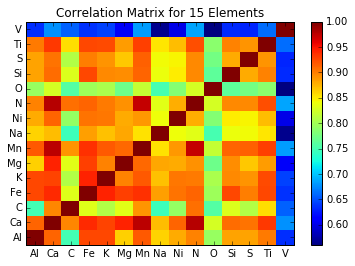

In [7]:
# get correlation matrix
ap_corr = get_corr(ap_chem)

[ 0.812  0.901  0.928  0.951  0.962  0.969  0.975  0.981  0.986  0.99
  0.993  0.996  0.998  0.999  1.   ]


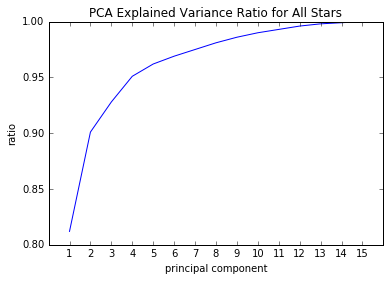

In [35]:
# get explained variance ratios
ap_chem_pca = get_PCA(ap_chem)

[ 0.93   0.962  0.976  0.987  0.993  0.995  0.997  0.998  0.999  1.     1.001
  1.001  1.001  1.001  1.001]


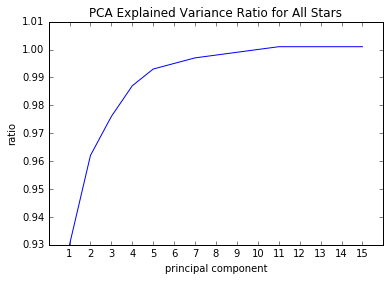

In [66]:
# load known members
known_clusters = np.loadtxt('table4.dat', usecols=(0, 1), dtype=('S', 'S'), unpack=True)
# names of all known clusters
known_clusters_names = known_clusters[1]
# names of clusters with significant number of members
clusters_names = np.array(["M107", "M13", "M5", "N6819", "M67"])
# APOGEE IDs of all known members
known_clusters_ID = known_clusters[0]
# get all known members
ap_members = np.array([np.where(ID == ap_ID)[0][0] for ID in known_clusters_ID])
# get members with all 15 elements
ap_members_15 = np.intersect1d(C_15, ap_members)
# array to save indexes of known members in all known clusters
ap_target = np.array([])
# array to save true labels of known clusters
ap_true_labels = np.array([])
# individual label for each cluster
index = 0
for name in clusters_names:
    # get members of a known cluster
    name_members_ID = known_clusters_ID[np.where(name == known_clusters_names)]
    name_members = np.array([np.where(ID == ap_ID)[0][0] for ID in name_members_ID])
    name_members_15 = np.intersect1d(name_members, ap_members_15)
    # save indexes of known members
    ap_target = np.concatenate((ap_target, name_members_15))
    # create labels for known members
    name_label = np.zeros(name_members_15.size) + index
    ap_true_labels = np.concatenate((ap_true_labels, name_label))
    index += 1
ap_target = ap_target.astype(int)
ap_target_chem = get_matrix(ap_target)
ap_target_chem_pca = get_PCA(ap_target_chem)
ap_true_labels = ap_true_labels.astype(int)

[ 0.          0.          0.          0.          0.00135135  0.00107105
  0.00058954  0.00055118  0.00045851  0.00054555]


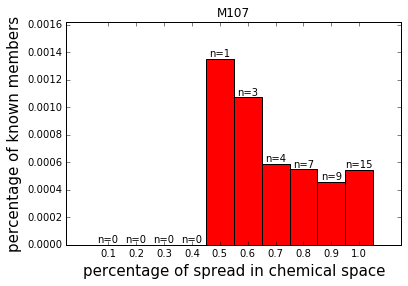

[ 0.          0.          0.          1.          0.4         0.17241379
  0.07228916  0.07586207  0.05238095  0.06756757]


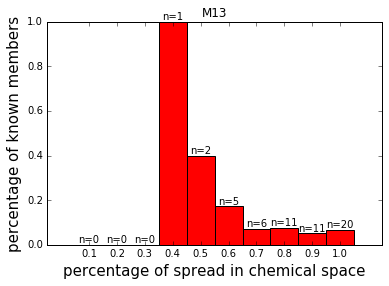

[ 0.          0.          1.          0.7         0.27906977  0.16842105
  0.11340206  0.09375     0.07828283  0.08317215]


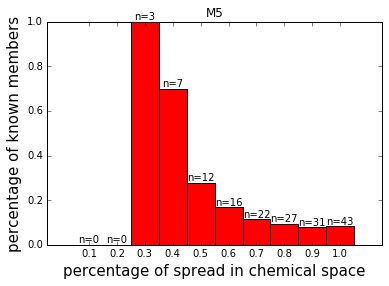

[ 0.          0.          0.00884956  0.00978793  0.00595948  0.00321543
  0.00268528  0.00257384  0.00218719  0.00206729]


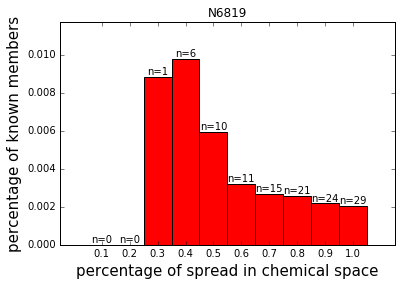

[ 0.          0.          0.05660377  0.02413793  0.01206273  0.00768386
  0.00510041  0.00353798  0.00255793  0.0027545 ]


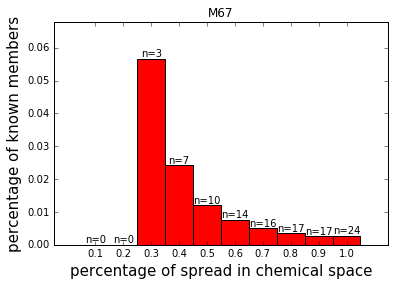

In [28]:
# # plot ratios of known members among stars with similar chemical abundances 
# list of percentages of spread in chemical space
pct_list = np.arange(0.1,1.1,0.1)
for n in range(5):
    # get indexes known members
    members = ap_target[np.where(ap_true_labels == n)[0]]
    member_ratios = np.array([])
    num_members = np.array([])
    # get a list of ratios of known members
    for pct in pct_list:
        similar = np.where(
                (np.abs(ap_AL_H - np.mean(ap_AL_H[members])) <= pct * np.max(np.abs(ap_AL_H[members] - np.mean(ap_AL_H[members])))) *
                (np.abs(ap_CA_H - np.mean(ap_CA_H[members])) <= pct * np.max(np.abs(ap_CA_H[members] - np.mean(ap_CA_H[members])))) *
                (np.abs(ap_C_H - np.mean(ap_C_H[members])) <= pct * np.max(np.abs(ap_C_H[members] - np.mean(ap_C_H[members])))) *
                (np.abs(ap_FE_H - np.mean(ap_FE_H[members])) <= pct * np.max(np.abs(ap_FE_H[members] - np.mean(ap_FE_H[members])))) *
                (np.abs(ap_K_H - np.mean(ap_K_H[members])) <= pct * np.max(np.abs(ap_K_H[members] - np.mean(ap_K_H[members])))) *
                (np.abs(ap_MG_H - np.mean(ap_MG_H[members])) <= pct * np.max(np.abs(ap_MG_H[members] - np.mean(ap_MG_H[members])))) *
                (np.abs(ap_MN_H - np.mean(ap_MN_H[members])) <= pct * np.max(np.abs(ap_MN_H[members] - np.mean(ap_MN_H[members])))) *
                (np.abs(ap_NA_H - np.mean(ap_NA_H[members])) <= pct * np.max(np.abs(ap_NA_H[members] - np.mean(ap_NA_H[members])))) *
                (np.abs(ap_NI_H - np.mean(ap_NI_H[members])) <= pct * np.max(np.abs(ap_NI_H[members] - np.mean(ap_NI_H[members])))) *
                (np.abs(ap_N_H - np.mean(ap_N_H[members])) <= pct * np.max(np.abs(ap_N_H[members] - np.mean(ap_N_H[members])))) *
                (np.abs(ap_O_H - np.mean(ap_O_H[members])) <= pct * np.max(np.abs(ap_O_H[members] - np.mean(ap_O_H[members])))) *
                (np.abs(ap_SI_H - np.mean(ap_SI_H[members])) <= pct * np.max(np.abs(ap_SI_H[members] - np.mean(ap_SI_H[members])))) *
                (np.abs(ap_S_H - np.mean(ap_S_H[members])) <= pct * np.max(np.abs(ap_S_H[members] - np.mean(ap_S_H[members])))) *
                (np.abs(ap_TI_H - np.mean(ap_TI_H[members])) <= pct * np.max(np.abs(ap_TI_H[members] - np.mean(ap_TI_H[members])))) *
                (np.abs(ap_V_H - np.mean(ap_V_H[members])) <= pct * np.max(np.abs(ap_V_H[members] - np.mean(ap_V_H[members])))))[0]
        overlap = np.intersect1d(members, similar)
        if similar.size == 0:
            member_ratios = np.append(member_ratios, 0.)
        else:
            member_ratios = np.append(member_ratios, overlap.size * 1.0 / similar.size)
        num_members = np.append(num_members, overlap.size)
    print member_ratios
    # plot 
    fig = plt.figure()
    rects1 = plt.bar(pct_list, member_ratios, width=0.1, color='r')
    # keep track of bars
    k = 0
    # add number of members for each bar
    for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height, 'n=%i'%(num_members[k]), ha='center', va='bottom')
        k += 1
    plt.title(clusters_names[n])
    plt.xlabel("percentage of spread in chemical space", fontsize=15)
    plt.ylabel("percentage of known members", fontsize=15)
    plt.ylim(0, np.minimum(member_ratios.max()*1.2, 1))
    plt.xticks(pct_list+0.05, pct_list)
    plt.show()

[ 0.          0.          0.          0.00318471  0.00084998  0.00050856
  0.00034217  0.00041571  0.00035484  0.00039403]


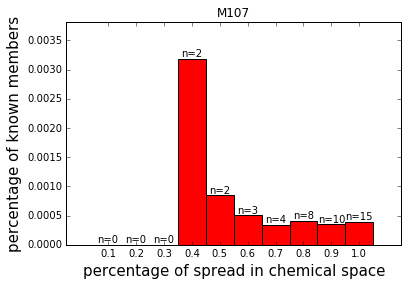

[ 0.          0.          0.          0.36363636  0.20833333  0.10666667
  0.05590062  0.0483871   0.03693182  0.041841  ]


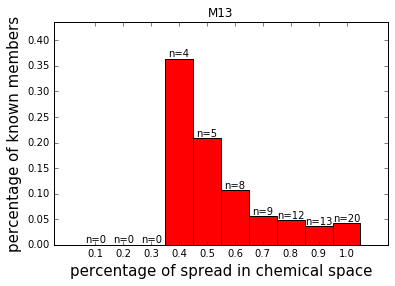

[ 0.          0.          0.57142857  0.38461538  0.17241379  0.11351351
  0.08227848  0.06535948  0.05494505  0.05295567]


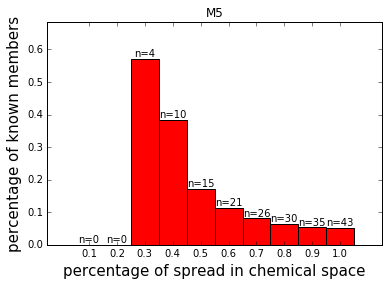

[ 0.          0.01470588  0.01054482  0.00444198  0.00353741  0.0022742
  0.00188805  0.00181413  0.00156342  0.00155221]


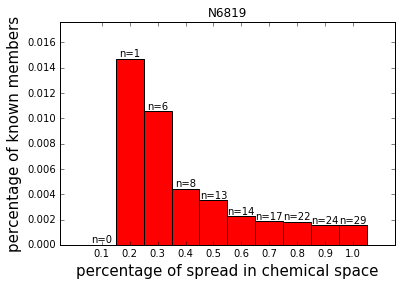

[ 0.          0.          0.02597403  0.01051051  0.00629723  0.00523378
  0.00382797  0.00303272  0.00232075  0.0023344 ]


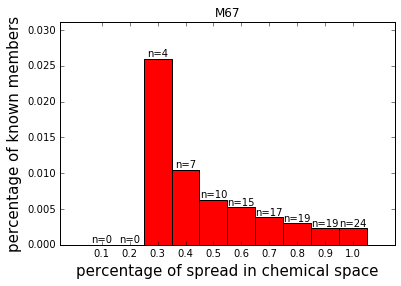

In [31]:
# # plot ratios of known members among stars with similar chemical abundances with 10 elements
# list of percentages of spread in chemical space
pct_list = np.arange(0.1 ,1.1, 0.1)
for n in range(5):
    # get indexes known members
    members = ap_target[np.where(ap_true_labels == n)[0]]
    member_ratios = np.array([])
    num_members = np.array([])
    # get a list of ratios of known members
    for pct in pct_list:
        similar = np.where(
                (np.abs(ap_AL_H - np.mean(ap_AL_H[members])) <= pct * np.max(np.abs(ap_AL_H[members] - np.mean(ap_AL_H[members])))) *
                (np.abs(ap_CA_H - np.mean(ap_CA_H[members])) <= pct * np.max(np.abs(ap_CA_H[members] - np.mean(ap_CA_H[members])))) *
                # (np.abs(ap_C_H - np.mean(ap_C_H[members])) <= pct * np.max(np.abs(ap_C_H[members] - np.mean(ap_C_H[members])))) *
                (np.abs(ap_FE_H - np.mean(ap_FE_H[members])) <= pct * np.max(np.abs(ap_FE_H[members] - np.mean(ap_FE_H[members])))) *
                (np.abs(ap_K_H - np.mean(ap_K_H[members])) <= pct * np.max(np.abs(ap_K_H[members] - np.mean(ap_K_H[members])))) *
                (np.abs(ap_MG_H - np.mean(ap_MG_H[members])) <= pct * np.max(np.abs(ap_MG_H[members] - np.mean(ap_MG_H[members])))) *
                (np.abs(ap_MN_H - np.mean(ap_MN_H[members])) <= pct * np.max(np.abs(ap_MN_H[members] - np.mean(ap_MN_H[members])))) *
                # (np.abs(ap_NA_H - np.mean(ap_NA_H[members])) <= pct * np.max(np.abs(ap_NA_H[members] - np.mean(ap_NA_H[members])))) *
                (np.abs(ap_NI_H - np.mean(ap_NI_H[members])) <= pct * np.max(np.abs(ap_NI_H[members] - np.mean(ap_NI_H[members])))) *
                (np.abs(ap_N_H - np.mean(ap_N_H[members])) <= pct * np.max(np.abs(ap_N_H[members] - np.mean(ap_N_H[members])))) *
                # (np.abs(ap_O_H - np.mean(ap_O_H[members])) <= pct * np.max(np.abs(ap_O_H[members] - np.mean(ap_O_H[members])))) *
                (np.abs(ap_SI_H - np.mean(ap_SI_H[members])) <= pct * np.max(np.abs(ap_SI_H[members] - np.mean(ap_SI_H[members])))) *
                (np.abs(ap_S_H - np.mean(ap_S_H[members])) <= pct * np.max(np.abs(ap_S_H[members] - np.mean(ap_S_H[members])))) # *
                # (np.abs(ap_TI_H - np.mean(ap_TI_H[members])) <= pct * np.max(np.abs(ap_TI_H[members] - np.mean(ap_TI_H[members])))) *
                # (np.abs(ap_V_H - np.mean(ap_V_H[members])) <= pct * np.max(np.abs(ap_V_H[members] - np.mean(ap_V_H[members]))))
                )[0]
        overlap = np.intersect1d(members, similar)
        if similar.size == 0:
            member_ratios = np.append(member_ratios, 0.)
        else:
            member_ratios = np.append(member_ratios, overlap.size * 1.0 / similar.size)
        num_members = np.append(num_members, overlap.size)
    print member_ratios
    # plot 
    fig = plt.figure()
    rects1 = plt.bar(pct_list, member_ratios, width=0.1, color='r')
    # keep track of bars
    k = 0
    # add number of members for each bar
    for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height, 'n=%i'%(num_members[k]), ha='center', va='bottom')
        k += 1
    plt.title(clusters_names[n])
    plt.xlabel("percentage of spread in chemical space", fontsize=15)
    plt.ylabel("percentage of known members", fontsize=15)
    plt.ylim(0, np.minimum(member_ratios.max()*1.2, 1))
    plt.xticks(pct_list+0.05, pct_list)
    plt.show()

[ 0.          0.          0.          0.002331    0.00119119  0.0009919
  0.00043469  0.00034247  0.00028868  0.00032336]


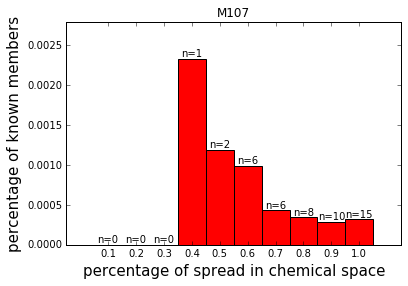

[ 0.          0.          0.125       0.05        0.04375     0.04        0.03125
  0.02617801  0.02191781  0.02219756]


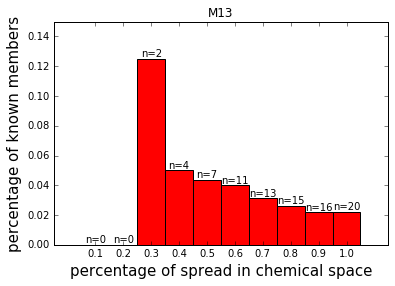

[ 0.          0.04        0.04716981  0.0412844   0.03773585  0.04102564
  0.03427173  0.03255814  0.02694611  0.02602906]


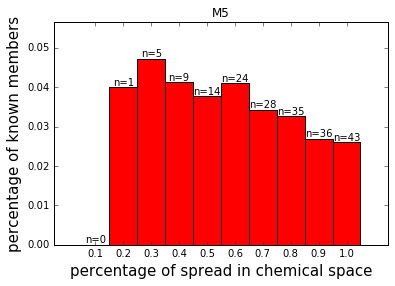

[ 0.          0.01        0.00790514  0.00511322  0.00379834  0.00300541
  0.00249311  0.00217494  0.0018078   0.00168419]


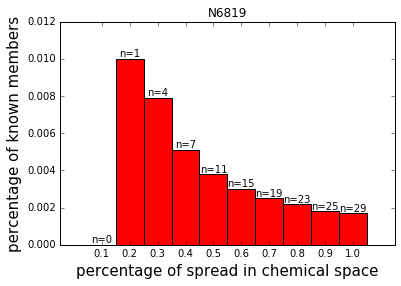

[ 0.01408451  0.01136364  0.00656096  0.00423504  0.00268181  0.0020172
  0.0014809   0.00115544  0.00104759  0.00101373]


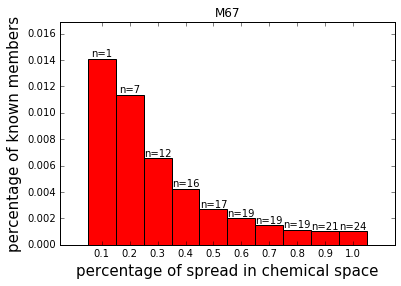

In [44]:
# # plot ratios of known members among stars with similar chemical abundances 
# list of percentages of spread in chemical space
pct_list = np.arange(0.1,1.1,0.1)
for n in range(5):
    # get indexes known members
    members = ap_target[np.where(ap_true_labels == n)[0]]
    members_C_15 = np.array([np.where(C_15 == member)[0][0] for member in members])
    member_ratios = np.array([])
    num_members = np.array([])
    # get a list of ratios of known members
    for pct in pct_list:
        similar = np.where(
                  (np.abs(ap_chem_pca[:,0] - np.mean(ap_chem_pca[:,0][members_C_15])) <= pct * np.max(np.abs(ap_chem_pca[:,0][members_C_15] - np.mean(ap_chem_pca[:,0][members_C_15])))) *
                  (np.abs(ap_chem_pca[:,1] - np.mean(ap_chem_pca[:,1][members_C_15])) <= pct * np.max(np.abs(ap_chem_pca[:,1][members_C_15] - np.mean(ap_chem_pca[:,1][members_C_15])))) *
                  (np.abs(ap_chem_pca[:,2] - np.mean(ap_chem_pca[:,2][members_C_15])) <= pct * np.max(np.abs(ap_chem_pca[:,2][members_C_15] - np.mean(ap_chem_pca[:,2][members_C_15])))) *
                  (np.abs(ap_chem_pca[:,3] - np.mean(ap_chem_pca[:,3][members_C_15])) <= pct * np.max(np.abs(ap_chem_pca[:,3][members_C_15] - np.mean(ap_chem_pca[:,3][members_C_15]))))
                  )[0]
        overlap = np.intersect1d(members_C_15, similar)
        if similar.size == 0:
            member_ratios = np.append(member_ratios, 0.)
        else:
            member_ratios = np.append(member_ratios, overlap.size * 1.0 / similar.size)
        num_members = np.append(num_members, overlap.size)
    print member_ratios
    # plot 
    fig = plt.figure()
    rects1 = plt.bar(pct_list, member_ratios, width=0.1, color='r')
    # keep track of bars
    k = 0
    # add number of members for each bar
    for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height, 'n=%i'%(num_members[k]), ha='center', va='bottom')
        k += 1
    plt.title(clusters_names[n])
    plt.xlabel("percentage of spread in chemical space", fontsize=15)
    plt.ylabel("percentage of known members", fontsize=15)
    plt.ylim(0, np.minimum(member_ratios.max()*1.2, 1))
    plt.xticks(pct_list+0.05, pct_list)
    plt.show()

[ 0.16666667  0.14285714  0.11627907  0.13043478  0.15384615  0.13432836
  0.12987013  0.02970297  0.0260521   0.00023248]


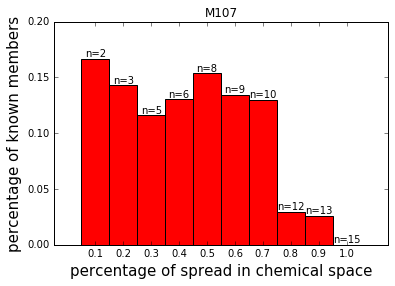

[ 0.05555556  0.06557377  0.08695652  0.1         0.09174312  0.096
  0.05017921  0.02698145  0.01565217  0.0118624 ]


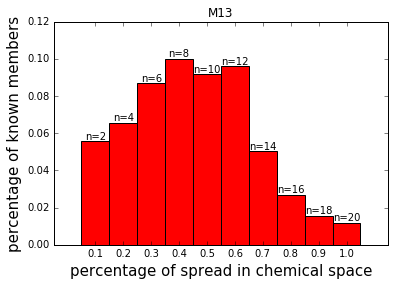

[ 0.0862069   0.08823529  0.06989247  0.07264957  0.07006369  0.04513889
  0.0249584   0.02672956  0.01628804  0.00545616]


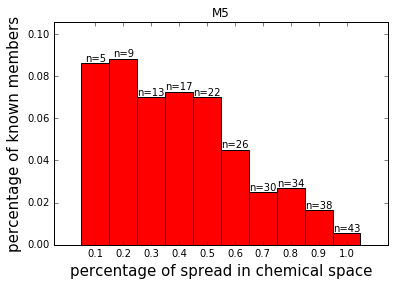

[ 0.03846154  0.02739726  0.02486188  0.01837672  0.02074689  0.01178101
  0.01047669  0.00515695  0.00238379  0.00094459]


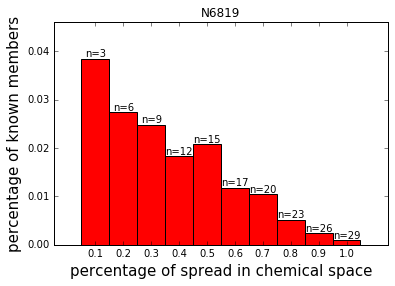

[ 0.02521008  0.0245098   0.02857143  0.02070393  0.02169982  0.01769912
  0.00399718  0.00243122  0.00066319  0.00034686]


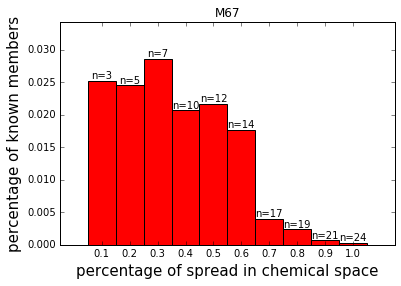

In [107]:
# Use Mahalanobis distance to do the same as above
width = 0.1
index_prin_comp = np.arange(4)
pct_list = np.arange(0.1,1.1,width)
for n in range(5):
    # get indexes known members
    members = ap_target[np.where(ap_true_labels == n)[0]]
    members_C_15 = np.array([np.where(C_15 == member)[0][0] for member in members])
    ap_chem_members_pca = ap_chem_pca[members_C_15][:,index_prin_comp]
    elliptic_env = EllipticEnvelope().fit(ap_chem_members_pca)
    mahal_elliptic_env = elliptic_env.mahalanobis(ap_chem_pca[:,index_prin_comp])
    mahal_members = mahal_elliptic_env[members_C_15]
    member_ratios = np.array([])
    num_members = np.array([])
    # get a list of ratios of known members
    for pct in pct_list:
        cut_off = np.percentile(mahal_members, pct*100.)
        similar = C_15[np.where(mahal_elliptic_env <= cut_off)[0]]
        overlap = np.intersect1d(members, similar)
        if similar.size == 0:
            member_ratios = np.append(member_ratios, 0.)
        else:
            member_ratios = np.append(member_ratios, overlap.size * 1.0 / similar.size)
        num_members = np.append(num_members, overlap.size)
    print member_ratios
    # plot 
    fig = plt.figure()
    rects1 = plt.bar(pct_list, member_ratios, width=width, color='r')
    # keep track of bars
    k = 0
    # add number of members for each bar
    for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height, 'n=%i'%(num_members[k]), ha='center', va='bottom')
        k += 1
    plt.title(clusters_names[n])
    plt.xlabel("percentage of spread in chemical space", fontsize=15)
    plt.ylabel("percentage of known members", fontsize=15)
    plt.ylim(0, np.minimum(member_ratios.max()*1.2, 1))
    plt.xticks(pct_list+width/2., pct_list)
    plt.show()

## Known Clusters

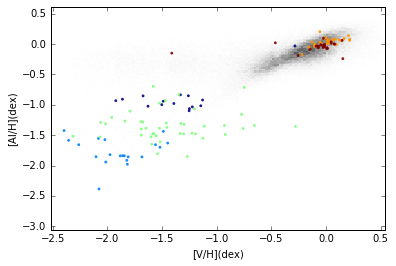

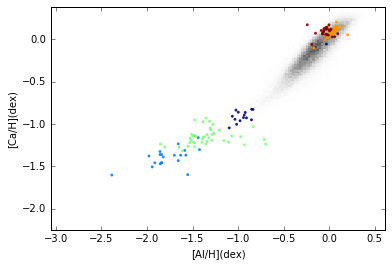

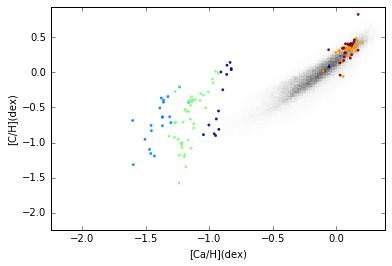

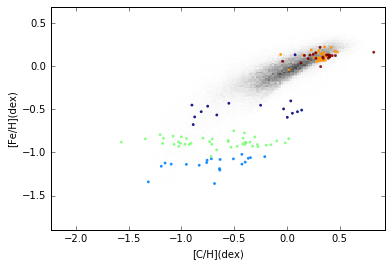

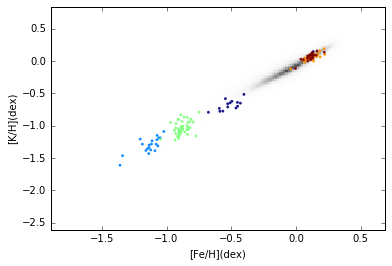

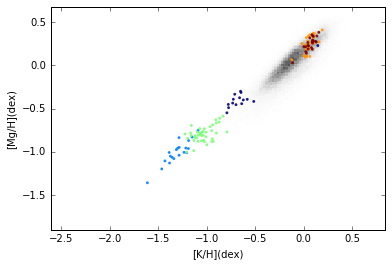

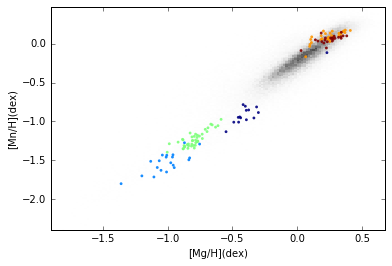

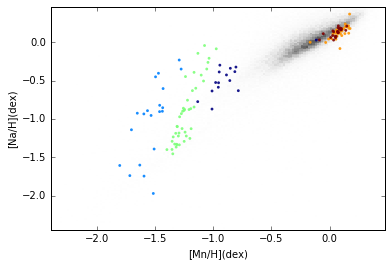

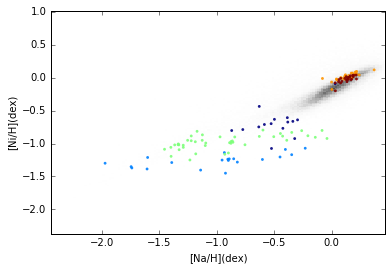

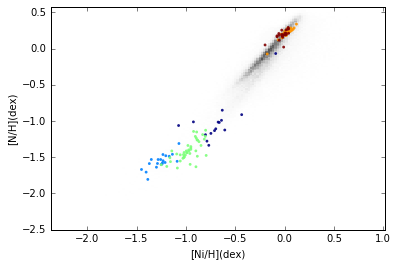

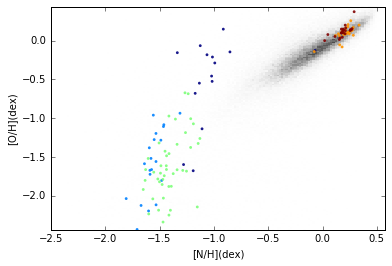

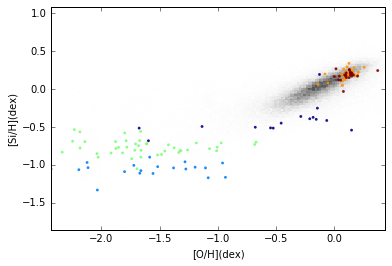

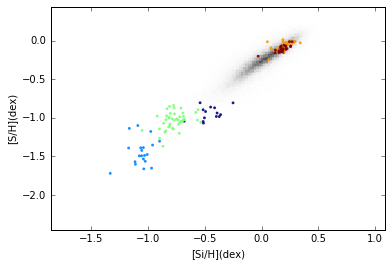

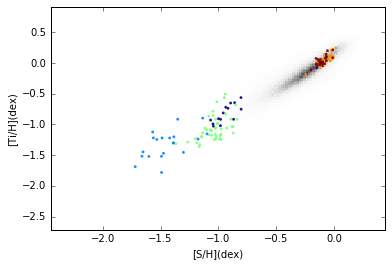

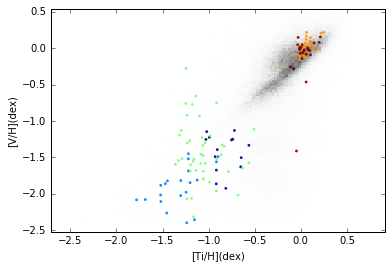

In [11]:
# plot known clusters against the background stars
for n in range(15):
    fig = plt.figure()
    plt.scatter(ap_target_chem[:,n-1], ap_target_chem[:,n], c=ap_true_labels, s=8, linewidths=0, alpha=0.9)
    plt.hist2d(ap_chem[:,n-1], ap_chem[:,n], bins=150, cmap="Greys", alpha=0.7)
    plt.xlabel("[%s/H](dex)"%elements[n-1])
    plt.ylabel("[%s/H](dex)"%elements[n])
    plt.plot()

## Apply KMeans

In [57]:
# perform KMeans on the chemical abundances of known clusters
kmeans = KMeans(5)
kmeans.fit(ap_target_chem)
labels = kmeans.labels_
print "v-measure-score is ", v_measure_score(labels, ap_true_labels)

v-measure-score is  0.684673746684


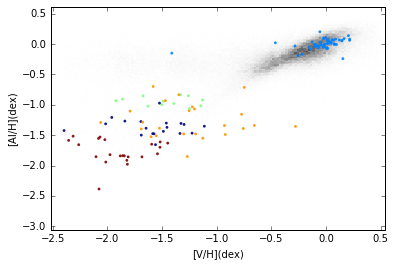

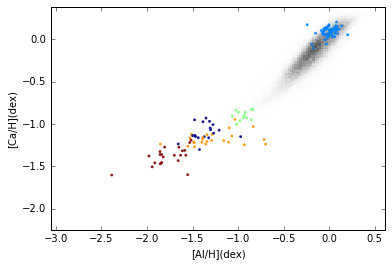

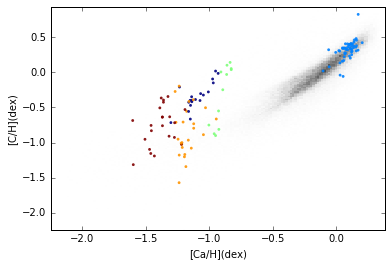

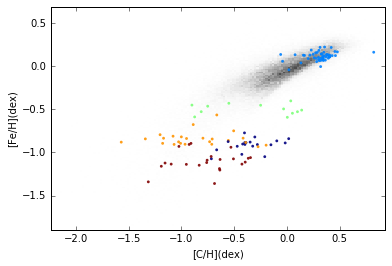

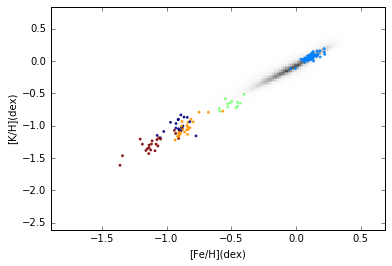

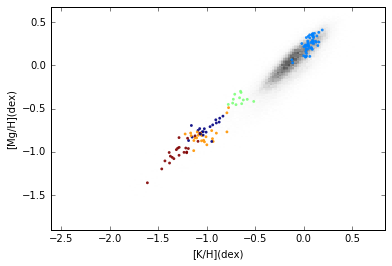

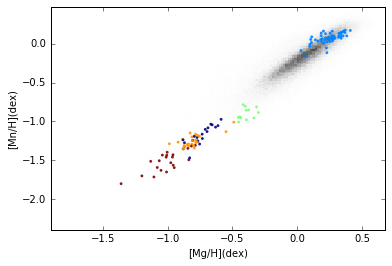

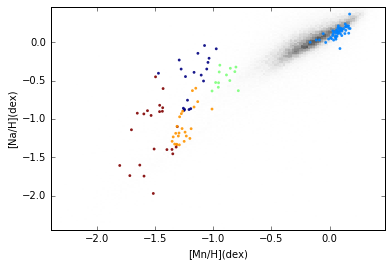

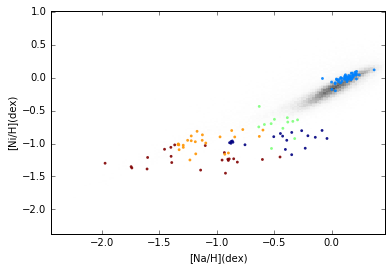

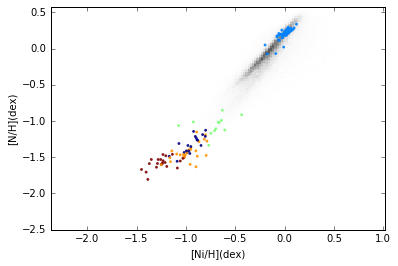

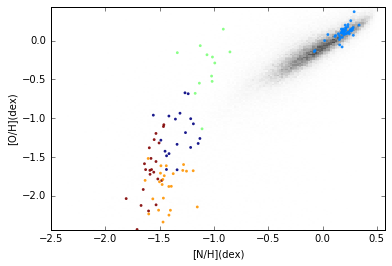

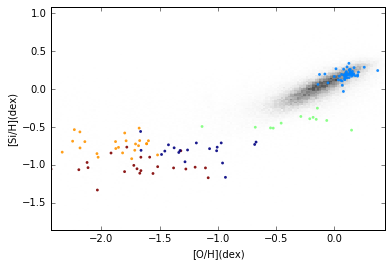

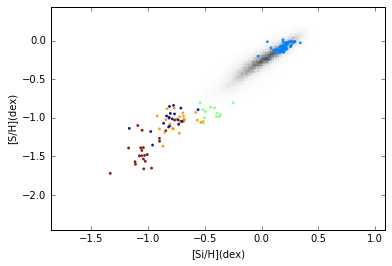

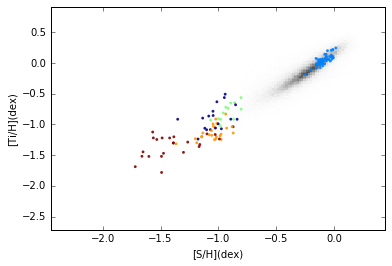

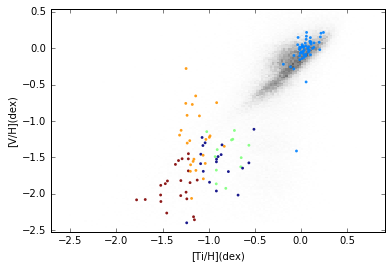

In [13]:
# plot results from KMeans
for n in range(15):
    fig = plt.figure()
    plt.scatter(ap_target_chem[:,n-1], ap_target_chem[:,n], c=labels, linewidths=0, s=8, alpha=0.9)
    plt.hist2d(ap_chem[:,n-1], ap_chem[:,n], bins=150, cmap="Greys", alpha=0.7)
    plt.xlabel("[%s/H](dex)"%elements[n-1])
    plt.ylabel("[%s/H](dex)"%elements[n])
    plt.plot()

## Apply GMM

In [50]:
from sklearn import mixture
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GMM(n_components=n_components, covariance_type=cv_type)
        gmm.fit(ap_target_chem)
        bic.append(gmm.bic(ap_target_chem))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
print best_gmm.get_params

v-measure-score is  0.691402980684


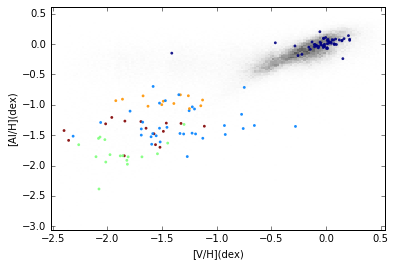

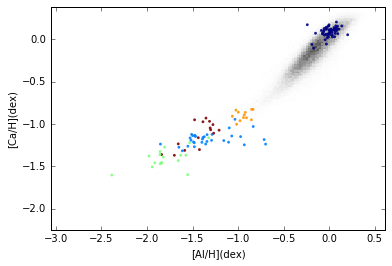

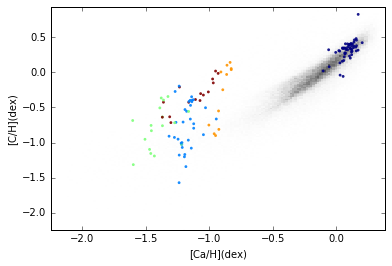

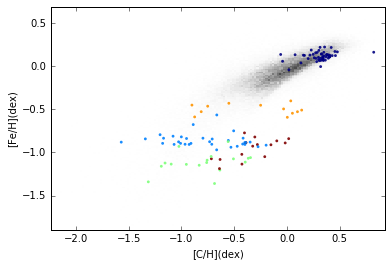

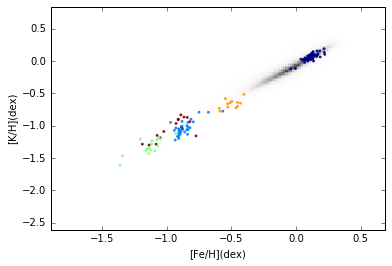

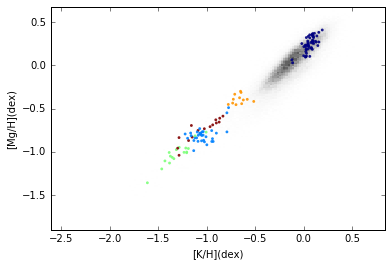

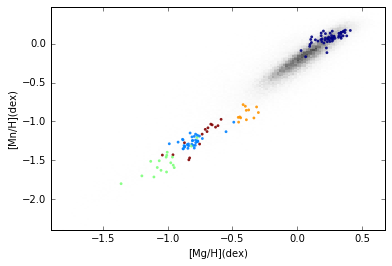

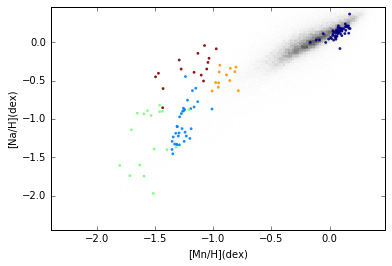

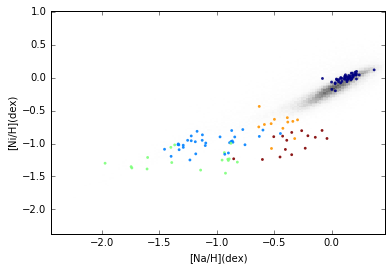

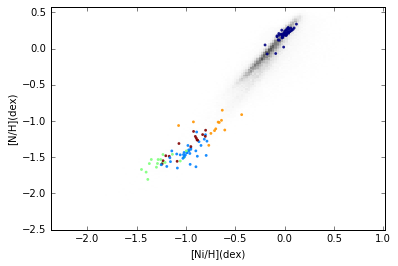

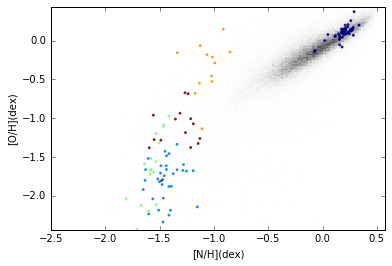

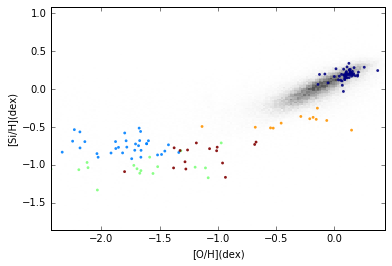

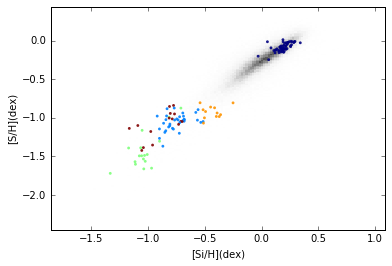

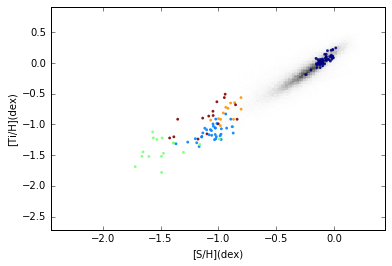

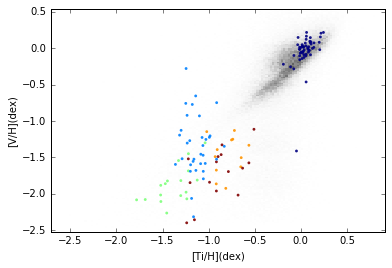

In [56]:
gmm_5 = mixture.GMM(n_components=5, covariance_type="full")
gmm_labels = gmm_5.fit_predict(ap_target_chem)
print "v-measure-score is ", v_measure_score(gmm_labels, ap_true_labels)
# plot results from KMeans
for n in range(15):
    fig = plt.figure()
    plt.scatter(ap_target_chem[:,n-1], ap_target_chem[:,n], c=gmm_labels, linewidths=0, s=8, alpha=0.9)
    plt.hist2d(ap_chem[:,n-1], ap_chem[:,n], bins=150, cmap="Greys", alpha=0.7)
    plt.xlabel("[%s/H](dex)"%elements[n-1])
    plt.ylabel("[%s/H](dex)"%elements[n])
    plt.plot()

In [14]:
# # load data from The Cannon
# load data from fits file
cannon_file = fits.open('results-unregularized-matched.fits')
cannon_file.info()
cannon_data = cannon_file[1].data
# APOGEE ID for stars
ca_ID = cannon_data.field('APOGEE_ID')
# Galactic Longitude
ca_l = cannon_data.field('GLON')
# Galactic Latitude 
ca_b = cannon_data.field('GLAT')
# log g
ca_LOGG = cannon_data.field('LOGG')
# Effective Temperature
ca_TEFF = cannon_data.field('TEFF')
# 15 elements
ca_AL_H = cannon_data.field("AL_H")
ca_CA_H = cannon_data.field("CA_H")
ca_C_H = cannon_data.field("C_H")
ca_FE_H = cannon_data.field('FE_H')
ca_K_H = cannon_data.field("K_H")
ca_MG_H = cannon_data.field("MG_H")
ca_MN_H = cannon_data.field("MN_H")
ca_NA_H = cannon_data.field("NA_H")
ca_NI_H = cannon_data.field("NI_H")
ca_N_H = cannon_data.field("N_H")
ca_O_H = cannon_data.field("O_H")
ca_SI_H = cannon_data.field("SI_H")
ca_S_H = cannon_data.field("S_H")
ca_TI_H = cannon_data.field("TI_H")
ca_V_H = cannon_data.field("V_H")

Filename: results-unregularized-matched.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      16   (9974,)      uint8   
1    Joined      BinTableHDU    351   150677R x 169C   [18A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 45A, 34A, 44A, 34A, 8A, I, 16A, E, E, E, E, E, E, D, D, D, D, J, J, 116A, J, I, E, J, 129A, J, 59A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 2E, 2E, 2E, 2E, 5A, 6A, 4A, I, 7E, 7E, 49E, 49E, 15E, 15E, 15E, 15E, E, E, E, E, E, E, E, E, E, 2A, J, 153A, 7J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, 15E, 15J, 18A, 12A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 17A, E, E, I, I, E, E, 20A, 737A, 665A, 50J, 50J, L]   


In [15]:
def get_matrix_cannon(C):
    """
    get the matrix that contains chemical abundances with 
    the shape (num_stars, num_elements) from the Cannon.
    
    :param C:
        indexes of stars
        
    :returns:
    a matrix that contains chemical abundances of stars with indexes
    """
    data = []
    data.append(ca_C_H[C])
    data.append(ca_FE_H[C])
    data.append(ca_N_H[C])
    data.append(ca_O_H[C])
    data.append(ca_MG_H[C])
    data.append(ca_SI_H[C])
    data.append(ca_NI_H[C])
    data.append(ca_AL_H[C])
    data.append(ca_CA_H[C])
    data.append(ca_MN_H[C])
    data.append(ca_NA_H[C])
    data.append(ca_S_H[C])
    data.append(ca_K_H[C])
    data.append(ca_TI_H[C])
    data.append(ca_V_H[C])
    data = np.array(data)
    data = data.T
    return data

In [16]:
# get stars with 15 elements
C_ca = np.where(
        (~np.isnan(ca_AL_H)) * 
        (~np.isnan(ca_CA_H)) * 
        (~np.isnan(ca_C_H)) *
        (~np.isnan(ca_FE_H)) * 
        (~np.isnan(ca_K_H)) * 
        (~np.isnan(ca_MG_H)) *
        (~np.isnan(ca_MN_H)) * 
        (~np.isnan(ca_NA_H)) * 
        (~np.isnan(ca_NI_H)) *
        (~np.isnan(ca_N_H)) * 
        (~np.isnan(ca_O_H)) * 
        (~np.isnan(ca_SI_H)) *
        (~np.isnan(ca_S_H)) * 
        (~np.isnan(ca_TI_H)) * 
        (~np.isnan(ca_V_H)))[0]
# get chemical abundances of all stars with 15 elements
ca_chem = get_matrix_cannon(C_ca)

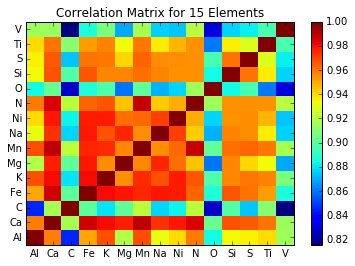

In [17]:
# get correlation matrix
ca_corr = get_corr(ca_chem)

[ 0.933  0.951  0.966  0.978  0.983  0.987  0.99   0.992  0.994  0.996
  0.997  0.998  0.999  0.999  0.999]


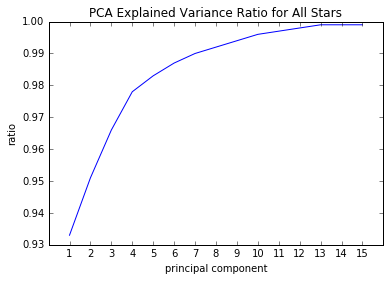

In [45]:
# get explained variance ratios
ca_chem_pca = get_PCA(ca_chem)

In [19]:
# get all known members
ca_members = np.array([np.where(ID == ca_ID)[0][0] for ID in known_clusters_ID])
# get members with all 15 elements
ca_members_15 = np.intersect1d(C_ca, ca_members)
# array to save indexes of known members in all known clusters
ca_target = np.array([])
# array to save true labels of known clusters
ca_true_labels = np.array([])
# individual label for each cluster
index = 0
for name in clusters_names:
    # get members of a known cluster
    name_members_ID = known_clusters_ID[np.where(name == known_clusters_names)]
    name_members = np.array([np.where(ID == ca_ID)[0][0] for ID in name_members_ID])
    name_members_15 = np.intersect1d(name_members, ca_members_15)
    # save indexes of known members
    ca_target = np.concatenate((ca_target, name_members_15))
    # create labels for known members
    name_label = np.zeros(name_members_15.size) + index
    ca_true_labels = np.concatenate((ca_true_labels, name_label))
    index += 1
ca_target = ca_target.astype(int)
ca_target_chem = get_matrix_cannon(ca_target)
ca_true_labels = ca_true_labels.astype(int)

/usr/users/bchen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in less_equal
/usr/users/bchen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in less_equal


[ 0.          0.02631579  0.01456311  0.0058548   0.00267261  0.00126769
  0.00079351  0.00051115  0.00038463  0.00036325]


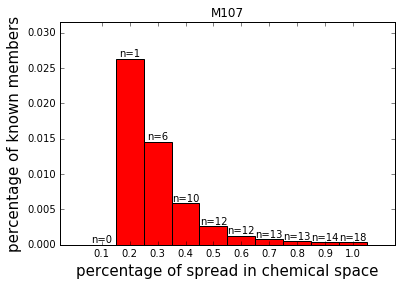

[ 0.          0.625       0.39393939  0.32894737  0.22929936  0.15151515
  0.07982583  0.04911742  0.03270803  0.02225705]


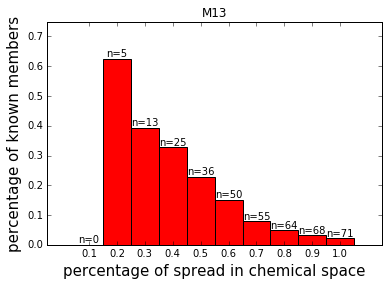

[ 0.          1.          0.66666667  0.59090909  0.28333333  0.16
  0.11985689  0.08833522  0.06818182  0.05631493]


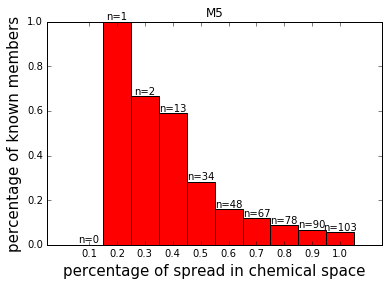

[ 0.          0.          0.17647059  0.05309735  0.02335456  0.01294498
  0.00712307  0.00485325  0.00339244  0.00328443]


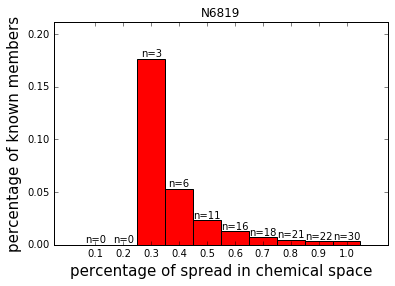

[ 0.          0.          1.          0.11111111  0.07070707  0.02445652
  0.01411509  0.00816993  0.00485751  0.00502092]


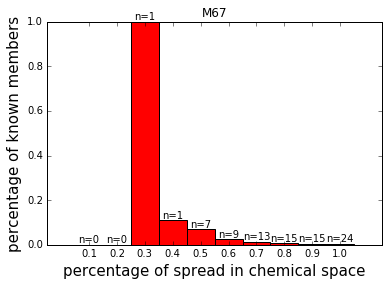

In [26]:
# # plot ratios of known members among stars with similar chemical abundances 
# list of percentages of spread in chemical space
pct_list = np.arange(0.1,1.1,0.1)
for n in range(5):
    # get indexes known members
    members = ca_target[np.where(ca_true_labels == n)[0]]
    member_ratios = np.array([])
    num_members = np.array([])
    # get a list of ratios of known members
    for pct in pct_list:
        similar = np.where(
                (np.abs(ca_AL_H - np.mean(ca_AL_H[members])) <= pct * np.max(np.abs(ca_AL_H[members] - np.mean(ca_AL_H[members])))) *
                (np.abs(ca_CA_H - np.mean(ca_CA_H[members])) <= pct * np.max(np.abs(ca_CA_H[members] - np.mean(ca_CA_H[members])))) *
                (np.abs(ca_C_H - np.mean(ca_C_H[members])) <= pct * np.max(np.abs(ca_C_H[members] - np.mean(ca_C_H[members])))) *
                (np.abs(ca_FE_H - np.mean(ca_FE_H[members])) <= pct * np.max(np.abs(ca_FE_H[members] - np.mean(ca_FE_H[members])))) *
                (np.abs(ca_K_H - np.mean(ca_K_H[members])) <= pct * np.max(np.abs(ca_K_H[members] - np.mean(ca_K_H[members])))) *
                (np.abs(ca_MG_H - np.mean(ca_MG_H[members])) <= pct * np.max(np.abs(ca_MG_H[members] - np.mean(ca_MG_H[members])))) *
                (np.abs(ca_MN_H - np.mean(ca_MN_H[members])) <= pct * np.max(np.abs(ca_MN_H[members] - np.mean(ca_MN_H[members])))) *
                (np.abs(ca_NA_H - np.mean(ca_NA_H[members])) <= pct * np.max(np.abs(ca_NA_H[members] - np.mean(ca_NA_H[members])))) *
                (np.abs(ca_NI_H - np.mean(ca_NI_H[members])) <= pct * np.max(np.abs(ca_NI_H[members] - np.mean(ca_NI_H[members])))) *
                (np.abs(ca_N_H - np.mean(ca_N_H[members])) <= pct * np.max(np.abs(ca_N_H[members] - np.mean(ca_N_H[members])))) *
                (np.abs(ca_O_H - np.mean(ca_O_H[members])) <= pct * np.max(np.abs(ca_O_H[members] - np.mean(ca_O_H[members])))) *
                (np.abs(ca_SI_H - np.mean(ca_SI_H[members])) <= pct * np.max(np.abs(ca_SI_H[members] - np.mean(ca_SI_H[members])))) *
                (np.abs(ca_S_H - np.mean(ca_S_H[members])) <= pct * np.max(np.abs(ca_S_H[members] - np.mean(ca_S_H[members])))) *
                (np.abs(ca_TI_H - np.mean(ca_TI_H[members])) <= pct * np.max(np.abs(ca_TI_H[members] - np.mean(ca_TI_H[members])))) *
                (np.abs(ca_V_H - np.mean(ca_V_H[members])) <= pct * np.max(np.abs(ca_V_H[members] - np.mean(ca_V_H[members])))))[0]
        overlap = np.intersect1d(members, similar)
        if similar.size == 0:
            member_ratios = np.append(member_ratios, 0.)
        else:
            member_ratios = np.append(member_ratios, overlap.size * 1.0 / similar.size)
        num_members = np.append(num_members, overlap.size)
    print member_ratios
    # plot 
    fig = plt.figure()
    rects1 = plt.bar(pct_list, member_ratios, width=0.1, color='r')
    # keep track of bars
    k = 0
    # add number of members for each bar
    for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height, 'n=%i'%(num_members[k]), ha='center', va='bottom')
        k += 1
    plt.title(clusters_names[n])
    plt.xlabel("percentage of spread in chemical space", fontsize=15)
    plt.ylabel("percentage of known members", fontsize=15)
    plt.ylim(0, np.minimum(member_ratios.max()*1.2, 1))
    plt.xticks(pct_list+0.05, pct_list)
    plt.show()

/usr/users/bchen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in less_equal
/usr/users/bchen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in less_equal


[ 0.          0.01915709  0.00658256  0.00245942  0.00124204  0.00071563
  0.00046398  0.0003264   0.00024726  0.00022191]


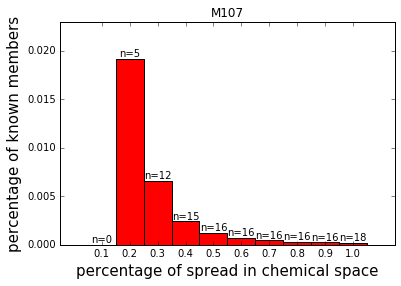

[ 0.          0.6         0.4         0.27659574  0.152       0.08146965
  0.04605263  0.03324808  0.02397498  0.01709196]


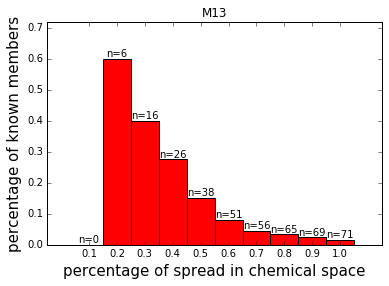

[ 0.          1.          0.20833333  0.21698113  0.15141956  0.10482529
  0.07355865  0.0556266   0.0426009   0.03537088]


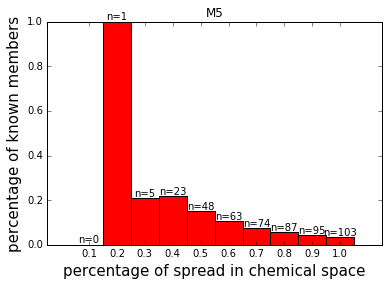

[ 0.          0.          0.02962963  0.01694915  0.00869565  0.00514635
  0.00358761  0.00273564  0.00207133  0.00205198]


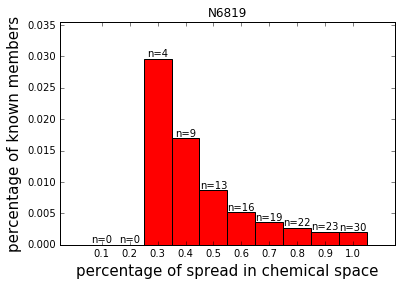

[ 0.          0.          0.05263158  0.01333333  0.01454545  0.0091954
  0.00619835  0.00437693  0.00293863  0.00296663]


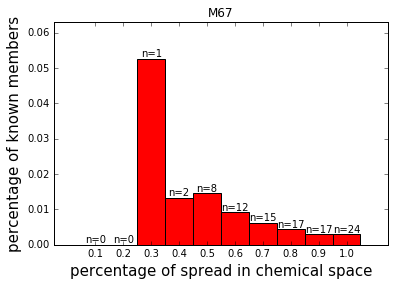

In [46]:
# # plot ratios of known members among stars with similar chemical abundances 
# list of percentages of spread in chemical space
pct_list = np.arange(0.1,1.1,0.1)
for n in range(5):
    # get indexes known members
    members = ca_target[np.where(ca_true_labels == n)[0]]
    member_ratios = np.array([])
    num_members = np.array([])
    # get a list of ratios of known members
    for pct in pct_list:
        similar = np.where(
                (np.abs(ca_AL_H - np.mean(ca_AL_H[members])) <= pct * np.max(np.abs(ca_AL_H[members] - np.mean(ca_AL_H[members])))) *
                (np.abs(ca_CA_H - np.mean(ca_CA_H[members])) <= pct * np.max(np.abs(ca_CA_H[members] - np.mean(ca_CA_H[members])))) *
                # (np.abs(ca_C_H - np.mean(ca_C_H[members])) <= pct * np.max(np.abs(ca_C_H[members] - np.mean(ca_C_H[members])))) *
                (np.abs(ca_FE_H - np.mean(ca_FE_H[members])) <= pct * np.max(np.abs(ca_FE_H[members] - np.mean(ca_FE_H[members])))) *
                (np.abs(ca_K_H - np.mean(ca_K_H[members])) <= pct * np.max(np.abs(ca_K_H[members] - np.mean(ca_K_H[members])))) *
                (np.abs(ca_MG_H - np.mean(ca_MG_H[members])) <= pct * np.max(np.abs(ca_MG_H[members] - np.mean(ca_MG_H[members])))) *
                (np.abs(ca_MN_H - np.mean(ca_MN_H[members])) <= pct * np.max(np.abs(ca_MN_H[members] - np.mean(ca_MN_H[members])))) *
                # (np.abs(ca_NA_H - np.mean(ca_NA_H[members])) <= pct * np.max(np.abs(ca_NA_H[members] - np.mean(ca_NA_H[members])))) *
                (np.abs(ca_NI_H - np.mean(ca_NI_H[members])) <= pct * np.max(np.abs(ca_NI_H[members] - np.mean(ca_NI_H[members])))) *
                (np.abs(ca_N_H - np.mean(ca_N_H[members])) <= pct * np.max(np.abs(ca_N_H[members] - np.mean(ca_N_H[members])))) *
                # (np.abs(ca_O_H - np.mean(ca_O_H[members])) <= pct * np.max(np.abs(ca_O_H[members] - np.mean(ca_O_H[members])))) *
                (np.abs(ca_SI_H - np.mean(ca_SI_H[members])) <= pct * np.max(np.abs(ca_SI_H[members] - np.mean(ca_SI_H[members])))) *
                (np.abs(ca_S_H - np.mean(ca_S_H[members])) <= pct * np.max(np.abs(ca_S_H[members] - np.mean(ca_S_H[members])))) # *
                # (np.abs(ca_TI_H - np.mean(ca_TI_H[members])) <= pct * np.max(np.abs(ca_TI_H[members] - np.mean(ca_TI_H[members])))) *
                # (np.abs(ca_V_H - np.mean(ca_V_H[members])) <= pct * np.max(np.abs(ca_V_H[members] - np.mean(ca_V_H[members]))))
                )[0]
        overlap = np.intersect1d(members, similar)
        if similar.size == 0:
            member_ratios = np.append(member_ratios, 0.)
        else:
            member_ratios = np.append(member_ratios, overlap.size * 1.0 / similar.size)
        num_members = np.append(num_members, overlap.size)
    print member_ratios
    # plot 
    fig = plt.figure()
    rects1 = plt.bar(pct_list, member_ratios, width=0.1, color='r')
    # keep track of bars
    k = 0
    # add number of members for each bar
    for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height, 'n=%i'%(num_members[k]), ha='center', va='bottom')
        k += 1
    plt.title(clusters_names[n])
    plt.xlabel("percentage of spread in chemical space", fontsize=15)
    plt.ylabel("percentage of known members", fontsize=15)
    plt.ylim(0, np.minimum(member_ratios.max()*1.2, 1))
    plt.xticks(pct_list+0.05, pct_list)
    plt.show()

[ 0.          0.02        0.00657895  0.00277008  0.00101999  0.00061355
  0.00048333  0.00033508  0.00027471  0.00028535]


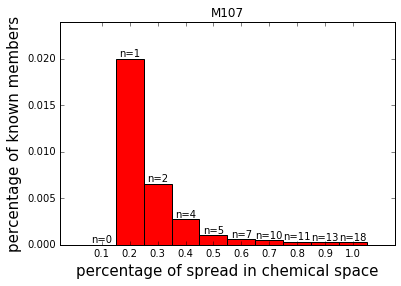

[ 1.          0.46153846  0.29268293  0.22826087  0.17766497  0.12532637
  0.08737864  0.06263048  0.04642857  0.03492376]


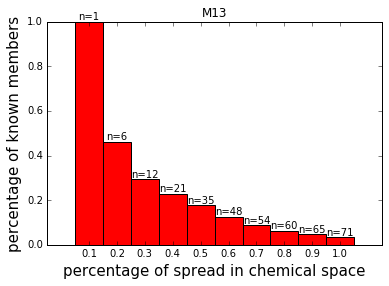

[ 1.          0.2962963   0.18103448  0.13580247  0.08931419  0.06692161
  0.05199746  0.04021211  0.03196347  0.02429818]


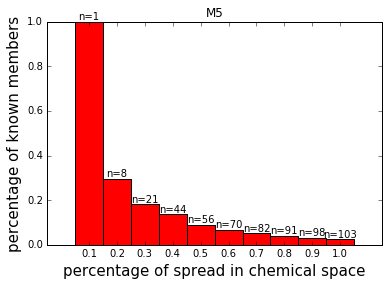

[ 0.          0.02684564  0.00724638  0.00378378  0.00438823  0.00295377
  0.00243475  0.0018337   0.00140192  0.00129803]


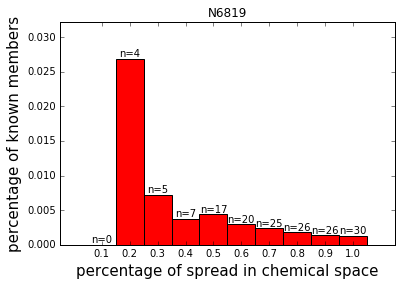

[ 0.          0.          0.00357143  0.00672495  0.00408859  0.00329897
  0.00224845  0.00188186  0.00160836  0.00155642]


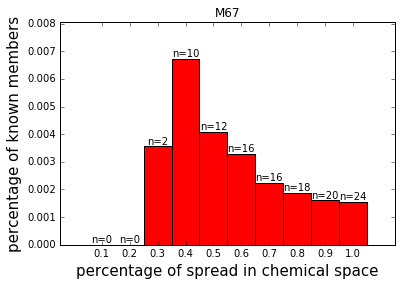

In [47]:
# # plot ratios of known members among stars with similar chemical abundances 
# list of percentages of spread in chemical space
pct_list = np.arange(0.1,1.1,0.1)
for n in range(5):
    # get indexes known members
    members = ca_target[np.where(ca_true_labels == n)[0]]
    members_C_ca = np.array([np.where(C_ca == member)[0][0] for member in members])
    member_ratios = np.array([])
    num_members = np.array([])
    # get a list of ratios of known members
    for pct in pct_list:
        similar = np.where(
                  (np.abs(ca_chem_pca[:,0] - np.mean(ca_chem_pca[:,0][members_C_ca])) <= pct * np.max(np.abs(ca_chem_pca[:,0][members_C_ca] - np.mean(ca_chem_pca[:,0][members_C_ca])))) *
                  (np.abs(ca_chem_pca[:,1] - np.mean(ca_chem_pca[:,1][members_C_ca])) <= pct * np.max(np.abs(ca_chem_pca[:,1][members_C_ca] - np.mean(ca_chem_pca[:,1][members_C_ca])))) *
                  (np.abs(ca_chem_pca[:,2] - np.mean(ca_chem_pca[:,2][members_C_ca])) <= pct * np.max(np.abs(ca_chem_pca[:,2][members_C_ca] - np.mean(ca_chem_pca[:,2][members_C_ca])))) *
                  (np.abs(ca_chem_pca[:,3] - np.mean(ca_chem_pca[:,3][members_C_ca])) <= pct * np.max(np.abs(ca_chem_pca[:,3][members_C_ca] - np.mean(ca_chem_pca[:,3][members_C_ca]))))
                  )[0]
        overlap = np.intersect1d(members_C_ca, similar)
        if similar.size == 0:
            member_ratios = np.append(member_ratios, 0.)
        else:
            member_ratios = np.append(member_ratios, overlap.size * 1.0 / similar.size)
        num_members = np.append(num_members, overlap.size)
    print member_ratios
    # plot 
    fig = plt.figure()
    rects1 = plt.bar(pct_list, member_ratios, width=0.1, color='r')
    # keep track of bars
    k = 0
    # add number of members for each bar
    for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height, 'n=%i'%(num_members[k]), ha='center', va='bottom')
        k += 1
    plt.title(clusters_names[n])
    plt.xlabel("percentage of spread in chemical space", fontsize=15)
    plt.ylabel("percentage of known members", fontsize=15)
    plt.ylim(0, np.minimum(member_ratios.max()*1.2, 1))
    plt.xticks(pct_list+0.05, pct_list)
    plt.show()

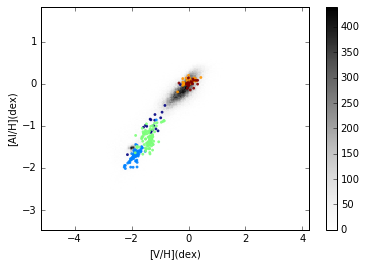

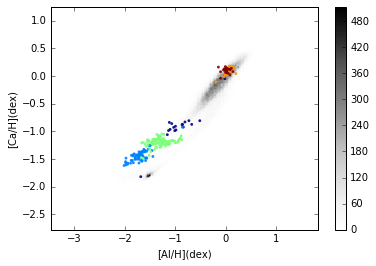

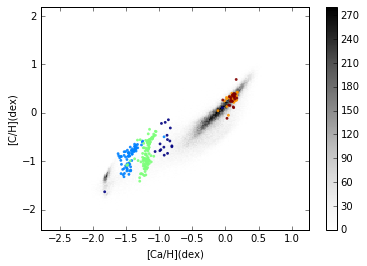

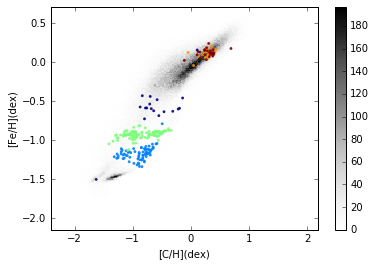

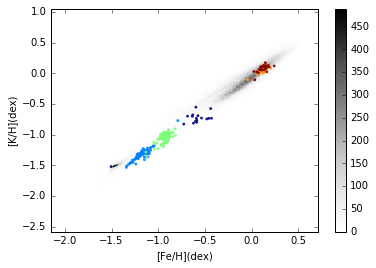

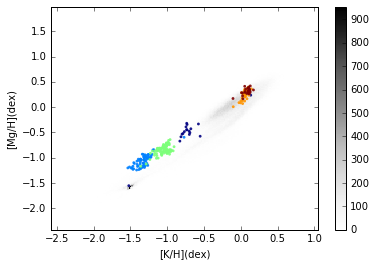

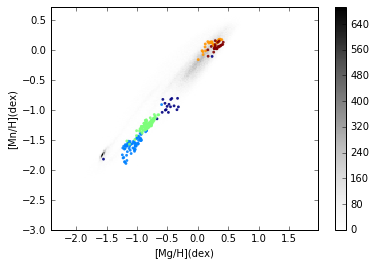

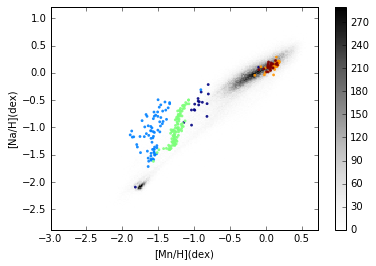

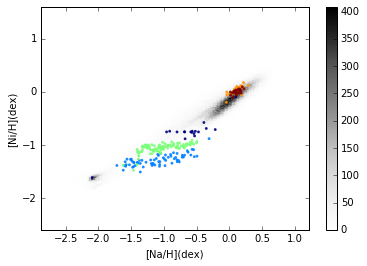

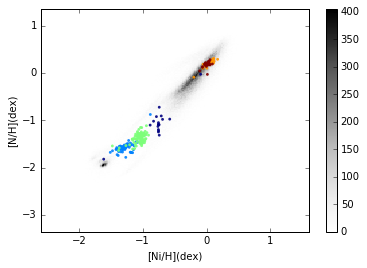

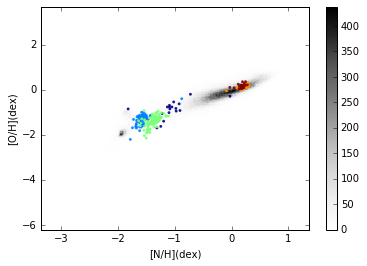

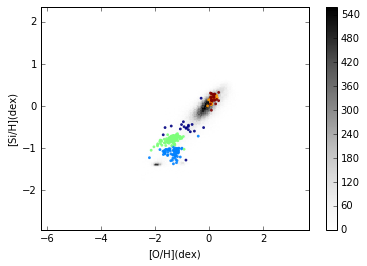

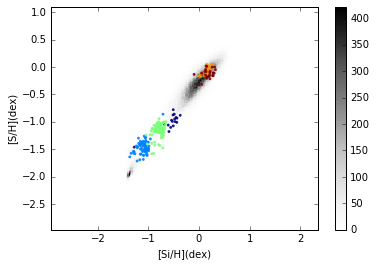

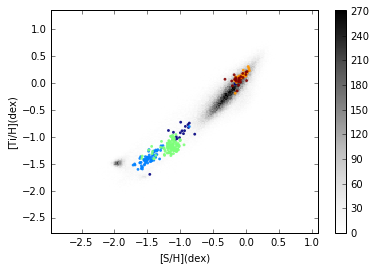

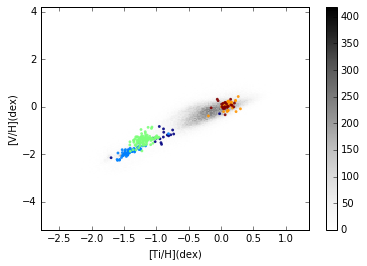

In [21]:
# plot known clusters against the background stars
for n in range(15):
    fig = plt.figure()
    plt.scatter(ca_target_chem[:,n-1], ca_target_chem[:,n], c=ca_true_labels, s=8, linewidths=0, alpha=0.9)
    plt.hist2d(ca_chem[:,n-1], ca_chem[:,n], bins=200, cmap="Greys")
    plt.colorbar()
    plt.xlabel("[%s/H](dex)"%elements[n-1])
    plt.ylabel("[%s/H](dex)"%elements[n])
    plt.plot()

In [58]:
# perform KMeans on the chemical abundances of known clusters
kmeans = KMeans(5)
kmeans.fit(ca_target_chem)
labels = kmeans.labels_
print "v-measure-score is ", v_measure_score(labels, ca_true_labels)

v-measure-score is  0.669120879285


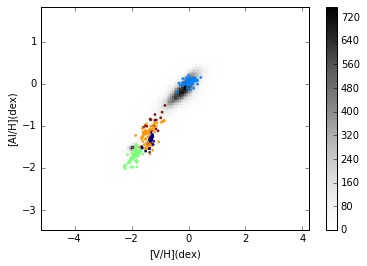

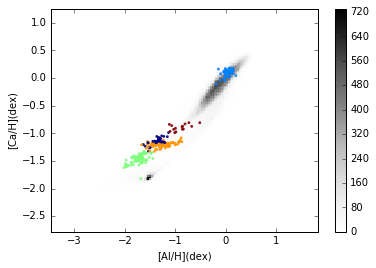

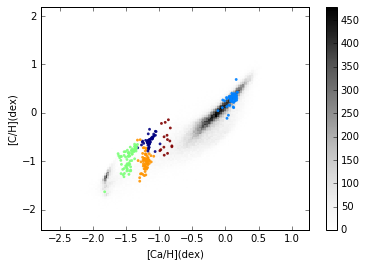

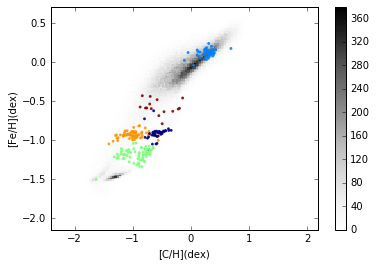

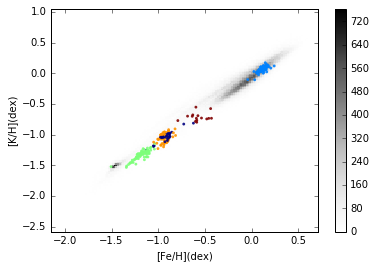

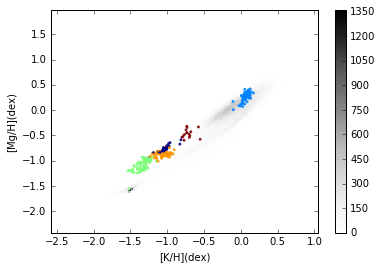

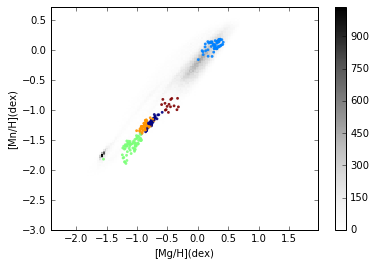

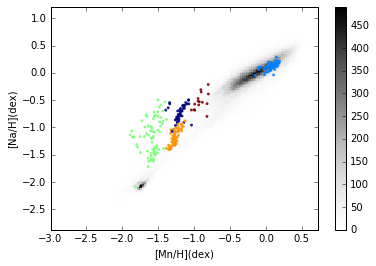

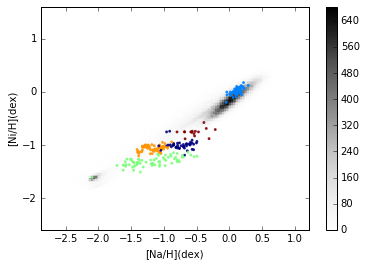

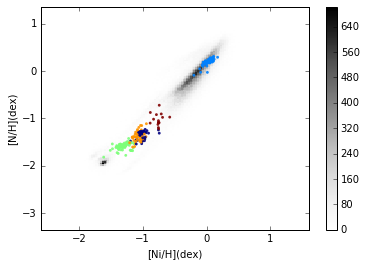

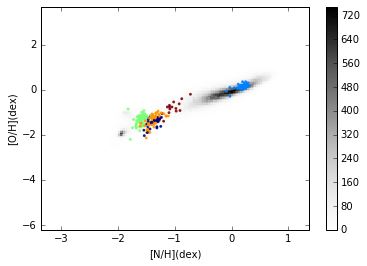

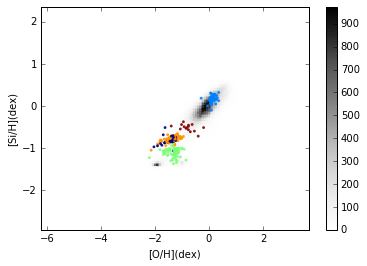

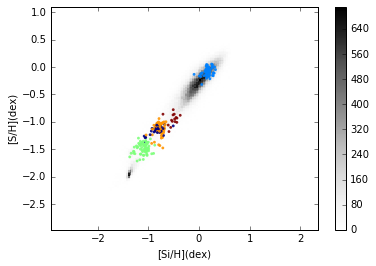

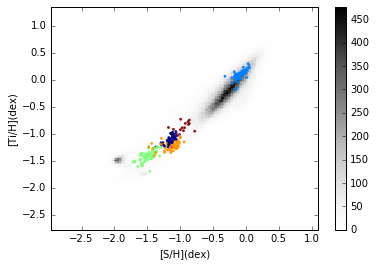

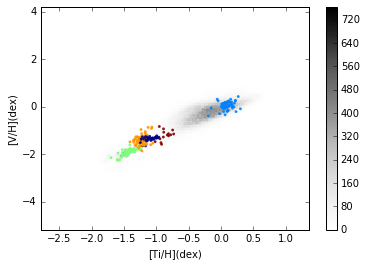

In [23]:
# plot results from KMeans
for n in range(15):
    fig = plt.figure()
    plt.scatter(ca_target_chem[:,n-1], ca_target_chem[:,n], c=labels, linewidths=0, s=8, alpha=0.9)
    plt.hist2d(ca_chem[:,n-1], ca_chem[:,n], bins=150, cmap="Greys")
    plt.colorbar()
    plt.xlabel("[%s/H](dex)"%elements[n-1])
    plt.ylabel("[%s/H](dex)"%elements[n])
    plt.plot()

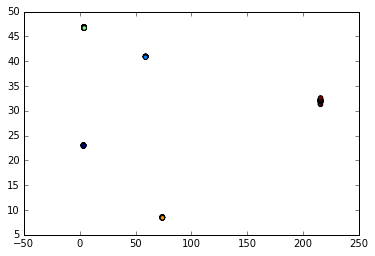

In [49]:
plt.scatter(ap_l[ap_target], ap_b[ap_target], c=ap_true_labels)
plt.show()

In [103]:
l = np.arange(100)
print np.percentile(l, 100)

99.0
